#Image classification of Cifar 10 dataset using Resnet 18 CNN model , albumentation image augmentation and gradcam image

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta

In [1]:
!python --version

Python 3.6.9


In [2]:
!pip install PyDrive

## Import pydrive modules

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Upload the cifar 10 image files from google drive to colab

Instead of downloading the cifar 10 dataset from web , a copy is saved in google drive.

In [5]:
downloaded = drive.CreateFile({'id':"1fohphdiuj_-zG7EwFnRzj4NQ3rZRu_PY"})   # replace the id with id of file you want to access
downloaded.GetContentFile('cifar10.zip')

In [6]:
from zipfile import ZipFile

## Extract the images into a local folder

In [7]:
with ZipFile('/content/cifar10.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [8]:
#!pip install albumentations

### Initialize the parameters

In [33]:
EPOCHS = 15
BATCH_SIZE = 128
TRAIN_DATASET_SIZE = 50000
BUCKET_SIZE = 5
NUMBER_OF_BATCHES =  TRAIN_DATASET_SIZE // BATCH_SIZE
NUMBER_OF_BUCKETS = NUMBER_OF_BATCHES // BUCKET_SIZE
DATAFOLDER = "/content/cifar10/"

## Import the model library from https://github.com/tfdeepnet/visionlib.git

In [34]:
!git clone https://github.com/tfdeepnet/visionlib.git

fatal: destination path 'visionlib' already exists and is not an empty directory.


In [35]:
!pip install -e /content/visionlib 


Obtaining file:///content/visionlib
  Found existing installation: visionlib 1.0.0
    Can't uninstall 'visionlib'. No files were found to uninstall.
  Running setup.py develop for visionlib


In [36]:
import visionlib.models as vl
import visionlib.utils as utl
#import visionlib.albumentations as A


In [37]:
%matplotlib inline

## Import the libraries

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np

## Prepare a list of albumentation for train and test data 





In [39]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform_list = [A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.9, rotate_limit=10, p=0.3),
                        A.HorizontalFlip(),
                        A.Normalize(mean=channel_means, std=channel_stdevs)] #,
                        #A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1)]
# Test Phase transformations
test_transform_list = [A.Normalize(mean=channel_means, std=channel_stdevs)]

##  Use the loaddata utility from visionlib library to load train and test data

In [40]:
trainloader, testloader = utl.loadalbumentationdata(DATAFOLDER , BATCH_SIZE , train_transform_list, test_transform_list )


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



img shape  torch.Size([128, 3, 32, 32])


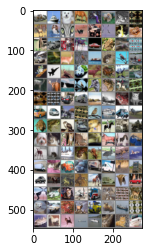

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("img shape " , images.shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Instantiate a resnet18 model to train and test the cifar 10 dataset


In [42]:
net = vl.ResNet18()

### Get the model summary alongwith the recepive field at each layer

In [43]:
#!pip install torchsummary
#from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

utl.summary(net.to(device), input_size=(3, 32, 32))

cuda
-----------------------------------------------------------------------------------------------
        Layer (type) |              Output Shape |         Param # |          RF out |         Jump in
            Conv2d-1 |          [-1, 64, 32, 32] |           1,728 |             622 |              64
       BatchNorm2d-2 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-3 |          [-1, 64, 32, 32] |          36,864 |             750 |              64
       BatchNorm2d-4 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-5 |          [-1, 64, 32, 32] |          36,864 |             878 |              64
       BatchNorm2d-6 |          [-1, 64, 32, 32] |             128 |               0 |               0
        BasicBlock-7 |          [-1, 64, 32, 32] |               0 |               0 |               0
            Conv2d-8 |          [-1, 64, 32, 32] |          36,864 |       

(tensor(11173962), tensor(11173962))

## Define a Loss function, optimizer and scheduler 

Let's use a Classification Cross-Entropy loss , SGD with momentum and StepLR to vary the learning rate progressively.



In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

## Train the network for 15 epochs



In [46]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    utl.train(epoch , trainloader, optimizer, net, criterion, NUMBER_OF_BUCKETS , device )
    scheduler.step()            

print('Finished Training')

[1,     1] loss: 0.032
[1,    79] loss: 1.804
[1,   157] loss: 1.527
[1,   235] loss: 1.363
[1,   313] loss: 1.229
[1,   391] loss: 1.128
[2,     1] loss: 0.014
[2,    79] loss: 1.055
[2,   157] loss: 1.021
[2,   235] loss: 0.931
[2,   313] loss: 0.931
[2,   391] loss: 0.856
[3,     1] loss: 0.011
[3,    79] loss: 0.817
[3,   157] loss: 0.786
[3,   235] loss: 0.777
[3,   313] loss: 0.770
[3,   391] loss: 0.735
[4,     1] loss: 0.012
[4,    79] loss: 0.694
[4,   157] loss: 0.696
[4,   235] loss: 0.673
[4,   313] loss: 0.671
[4,   391] loss: 0.651
[5,     1] loss: 0.009
[5,    79] loss: 0.635
[5,   157] loss: 0.635
[5,   235] loss: 0.601
[5,   313] loss: 0.581
[5,   391] loss: 0.579
[6,     1] loss: 0.009
[6,    79] loss: 0.552
[6,   157] loss: 0.572
[6,   235] loss: 0.555
[6,   313] loss: 0.541
[6,   391] loss: 0.568
[7,     1] loss: 0.005
[7,    79] loss: 0.474
[7,   157] loss: 0.433
[7,   235] loss: 0.410
[7,   313] loss: 0.407
[7,   391] loss: 0.404
[8,     1] loss: 0.005
[8,    79] 

### Let us display a batch of image from the test set to get familiar.



GroundTruth:   deer horse truck   cat  deer   car  frog plane  frog   dog   cat   dog   car truck  bird   car  bird  ship  deer  frog  deer   car  ship  frog  bird horse horse   cat   car plane   car  ship truck   cat  bird horse truck   dog  bird   dog   cat   dog  bird horse   dog   cat  deer  frog  deer   cat   dog  bird   car horse  frog  ship horse horse  frog   cat   cat   cat truck   cat   cat  frog  deer  bird  deer truck   dog   car horse horse   car plane horse  ship horse plane plane horse horse   car  frog  frog plane plane   dog   dog plane   cat   dog  frog horse horse  frog   car horse  bird horse  bird  deer  ship horse   dog  frog horse  deer   car  bird   cat   cat  ship horse truck   car  ship horse truck plane  frog   cat  bird  frog   car   car  frog


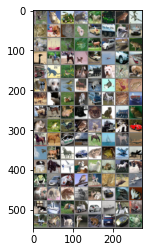

In [47]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

Okay, now let us see what the neural network thinks these examples above are:



In [48]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [49]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))

Predicted:   deer   cat truck   cat  deer   car  frog plane  frog   dog   cat   dog   car truck  bird   car  bird  ship  deer  frog  deer   car  ship  frog  bird horse horse   cat   car plane   car  ship truck plane  bird horse truck   dog  bird   dog   cat   dog  bird horse   dog plane  deer  frog  deer  bird   dog   dog   car horse  frog  ship horse horse  frog   cat   cat   cat truck   cat   cat  frog plane  bird  deer truck   dog   car horse horse   car plane horse  ship horse plane plane horse horse   car  frog  frog plane plane   dog   dog plane horse   dog   cat horse horse   dog   car horse  bird horse  bird  deer  ship horse   dog  frog  bird  deer   car  bird   cat   cat  ship horse truck   car  ship horse truck plane  frog   dog  bird  frog   car   car  frog


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [51]:
utl.test(testloader, net, device )

Accuracy of the network on the 10000 test images: 88 %


## Test accuracy 88% (randomly picking a class out of 10 classes).
Seems like the network learnt something.




## Test accuracy at each class level

In [52]:
   
misclassifiedimages = utl.get_validation_result_and_misclassifiedimages(net , device , classes , testloader ) 

Class accuracy 

Accuracy of plane : 90 % 

Accuracy of   car : 95 % 

Accuracy of  bird : 84 % 

Accuracy of   cat : 76 % 

Accuracy of  deer : 89 % 

Accuracy of   dog : 81 % 

Accuracy of  frog : 91 % 

Accuracy of horse : 92 % 

Accuracy of  ship : 93 % 

Accuracy of truck : 92 % 


 Accuracy of the network on the 10000 test images: 88.70 %


## Visualize misclassified test images

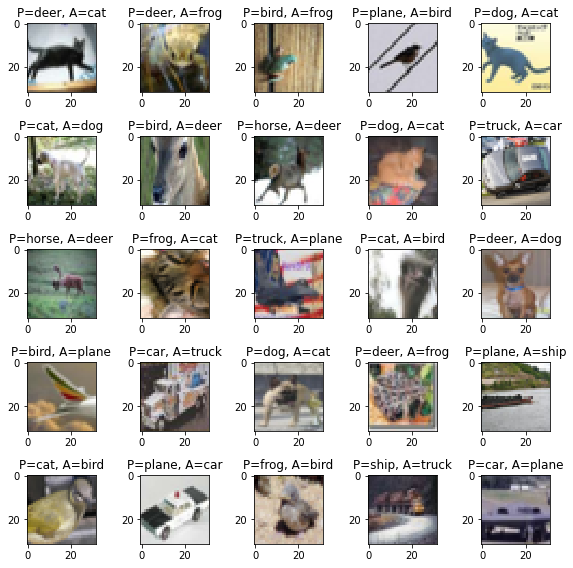

In [53]:
utl.view_misclassified_images(misclassifiedimages , classes)

In [54]:

import numpy as np
import matplotlib.pyplot as plt

def imshowgradcam(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

## GradCam of misclassified images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

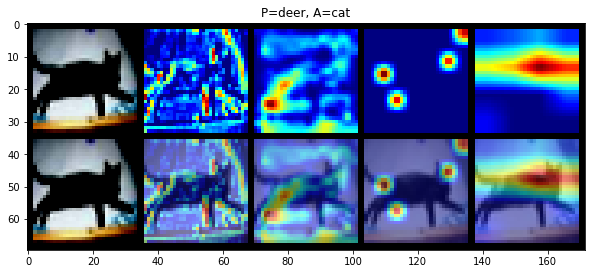

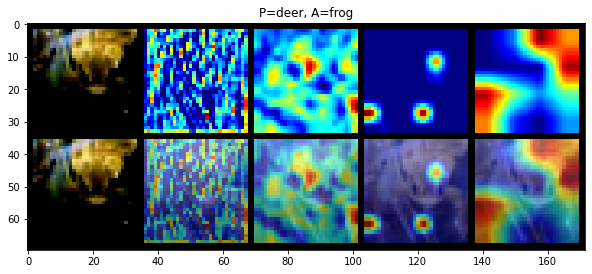

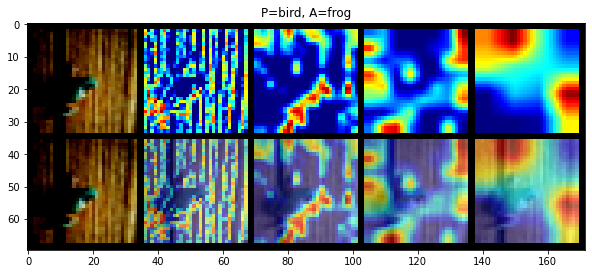

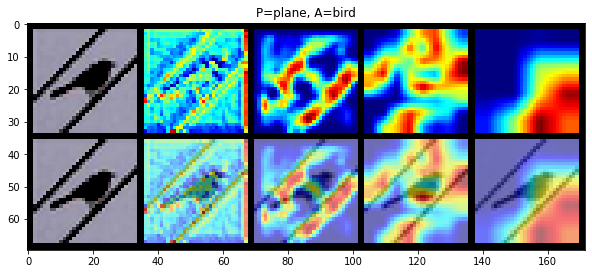

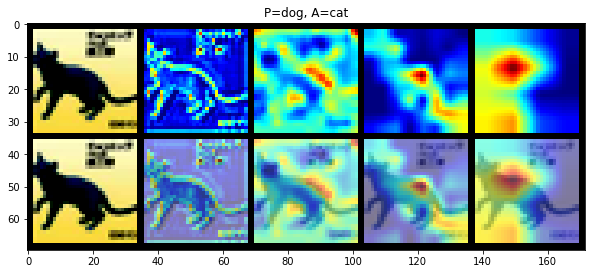

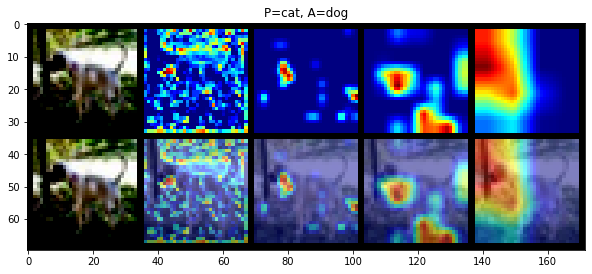

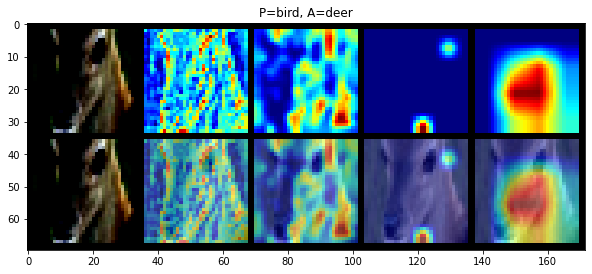

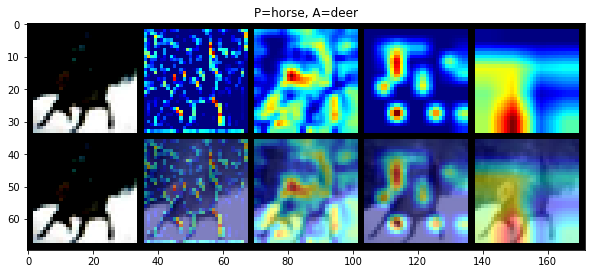

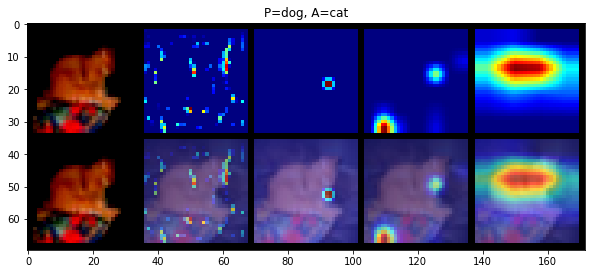

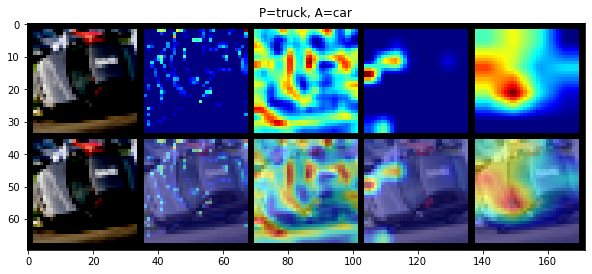

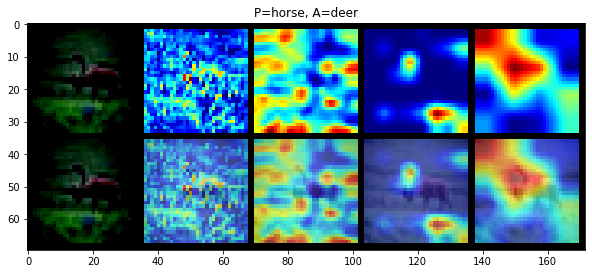

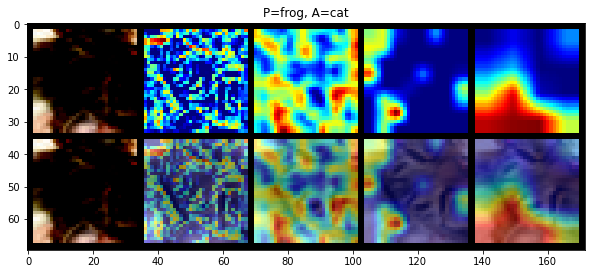

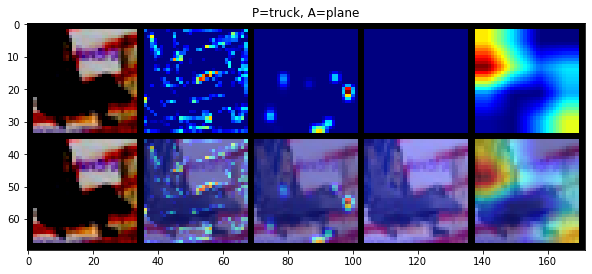

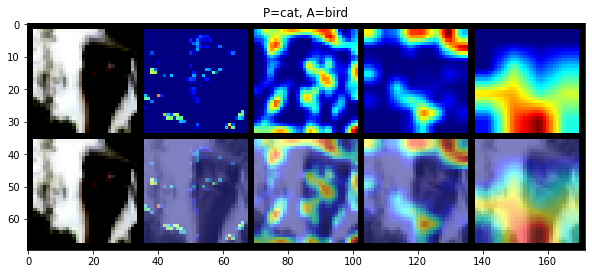

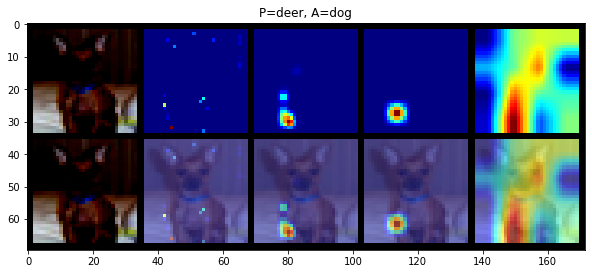

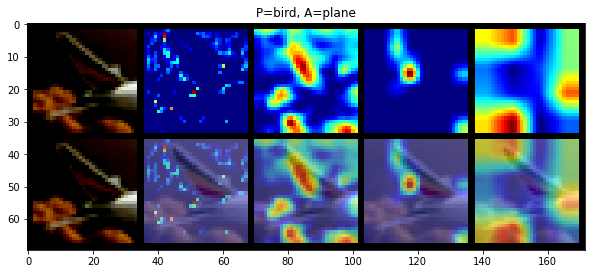

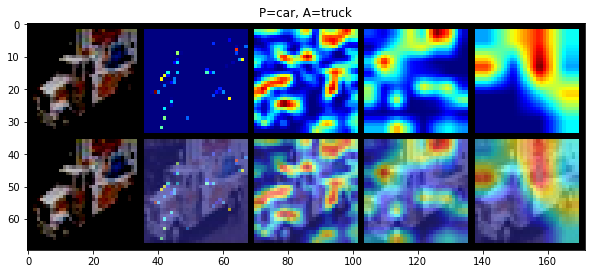

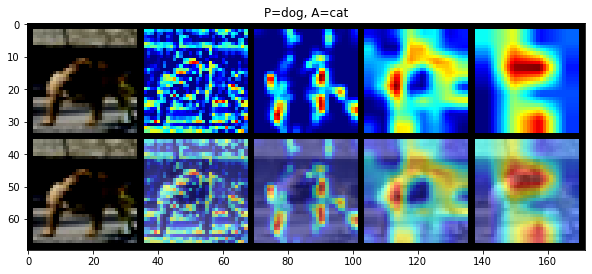

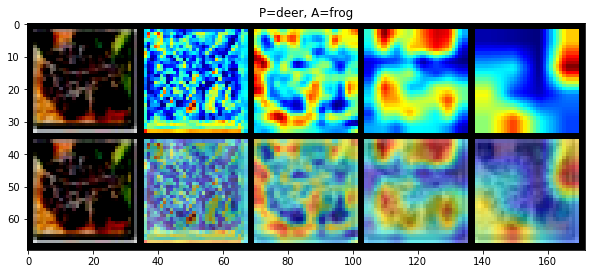

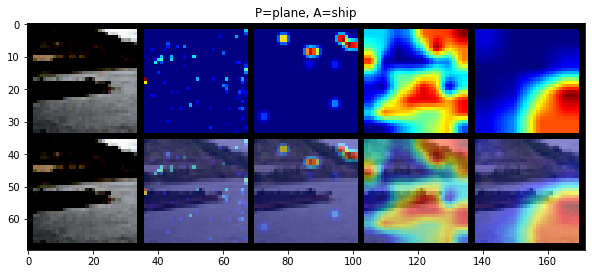

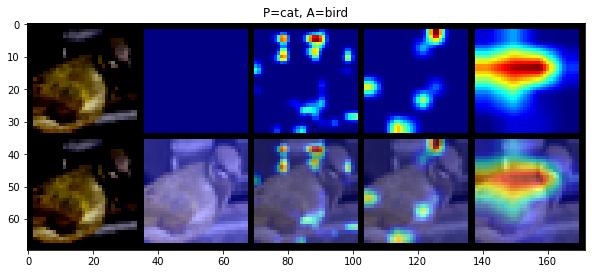

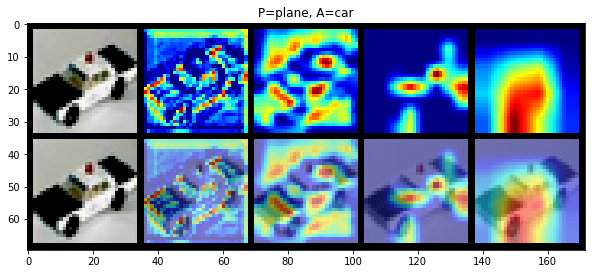

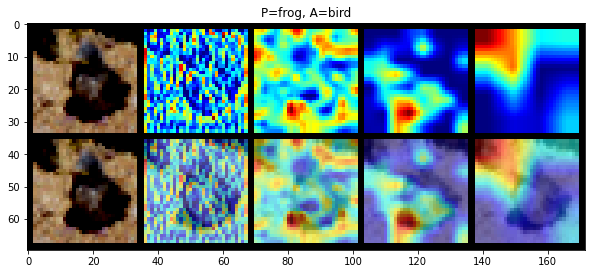

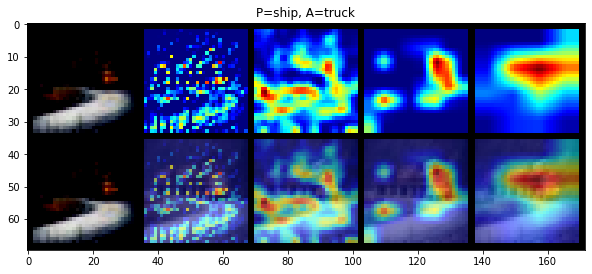

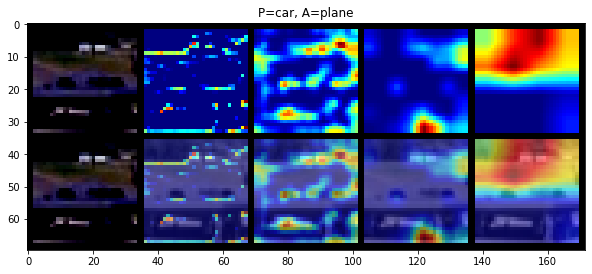

In [55]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(misclassifiedimages):
  images1 = [misclassifiedimages[i][0].cpu()]
  images2 =  [misclassifiedimages[i][0].cpu()]
  b = copy.deepcopy(net.to(device))
  output = net(misclassifiedimages[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = utl.GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(misclassifiedimages[i][0].clone().unsqueeze_(0))
    heatmap, result = utl.visualize_cam(mask,misclassifiedimages[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  imshowgradcam(grid_image,c = "P={}, A={}".format(str(classes[misclassifiedimages[i][1].data.cpu().numpy()]),str(classes[misclassifiedimages[i][2].data.cpu().numpy()])))